In [4]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import os
from tqdm import tqdm
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import models
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split 
from datetime import datetime
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd

# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa

from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import pandas as pd

from plotly.subplots import make_subplots
%matplotlib inline
import os
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

from scipy import signal
from scipy.io import wavfile




In [5]:
# train_audio_path='E:\\job\\for dataset\\for-2seconds\\training'
train_audio_path = r'E:\job\for dataset\for-2seconds\training'

dirs = [f for f in os.listdir(train_audio_path) if isdir(join(train_audio_path, f))]

dirs.sort()

print('Number of labels: ' + str(len(dirs)))

# Print the list of directories (labels)
print("List of directories (labels):")
print(dirs)




Number of labels: 2
List of directories (labels):
['fake', 'real']


In [6]:
# Calculate
number_of_recordings = []
for direct in dirs:
    waves = [f for f in os.listdir(join(train_audio_path, direct)) if f.endswith('.wav')]
    number_of_recordings.append(len(waves))
print(number_of_recordings)

[6978, 6978]


In [23]:
max_pad_length = 86
def extract_feature(file_name): 
    try:
        audio, sample_rate = librosa.load(file_name)
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        pad_width = max_pad_length - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, max(0, pad_width))), mode='constant')
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)  # Updated the print statement
        return None, None
    return np.array([mfccs])

    

def create_dataset(path,column_name):
    features=[]
    count=0
    for filename in tqdm(os.listdir(path)):
        data = extract_features_cnn(path+'/'+filename)
        features.append([data,column_name])
        
    featuresdf = pd.DataFrame(features, columns=['feature','class_label'])
    return featuresdf


def extract_features_cnn(file_name):
    try:
        audio,sample_rate = librosa.load(file_name)
        mfccs = librosa.feature.mfcc(y=audio,sr=sample_rate,n_mfcc=40)
        pad_width = max_pad_length - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')

    except:
        print("Error encountered while parsing the file: ", file_name)
        return None

    return mfccs

In [22]:
# Load and preprocess 'fake' data
fake_dir = os.path.join(train_audio_path, 'fake')
data_fake = []
for file_name in tqdm(os.listdir(fake_dir)):
    file_path = os.path.join(fake_dir, file_name)
    features = extract_feature(file_path)
    if features is not None:
        data_fake.append([features, 0])  # Append extracted features and label '0' for 'fake'


100%|██████████████████████████████████████████████████████████████████████████████| 6978/6978 [05:44<00:00, 20.26it/s]


In [24]:

# Load and preprocess 'real' data
real_dir = os.path.join(train_audio_path, 'real')
data_real = []
for file_name in tqdm(os.listdir(real_dir)):
    file_path = os.path.join(real_dir, file_name)
    features = extract_feature(file_path)
    if features is not None:
        data_real.append([features, 1])  # Append extracted features and label '1' for 'real'

# Concatenate the 'fake' and 'real' data
data = data_fake + data_real

# Shuffle the data (optional)
import random
random.shuffle(data)

# Split the data and labels
X_data = np.array([x[0] for x in data])
y_labels = np.array([x[1] for x in data])

# Optional: Display the first few rows of the dataset
dataset_df = pd.DataFrame(data, columns=['feature', 'class_label'])
print(dataset_df.head())

# Convert the data and labels to numpy arrays (if not done already)
data = X_data
labels = y_labels

100%|██████████████████████████████████████████████████████████████████████████████| 6978/6978 [09:30<00:00, 12.23it/s]


                                             feature  class_label
0  [[[-257.97443, -240.78937, -217.80576, -188.04...            0
1  [[[-250.70586, -166.1262, -132.01765, -147.018...            1
2  [[[-228.85704, -193.51448, -205.46909, -258.49...            0
3  [[[-162.98962, -130.51929, -139.14264, -149.39...            0
4  [[[-235.0666, -162.8045, -126.38308, -133.6843...            0


In [34]:
import numpy as np
import keras
from tensorflow.keras.layers import Input
from keras.layers import Dense, Dropout, Activation, Flatten 
from keras import models
from keras import layers

# causal conv
def __causal_gated_conv1D(x=None, filters=16, length=6, strides=1):
    def causal_gated_conv1D(x, filters, length, strides):
        x_in_1 = layers.Conv1D(filters=filters // 2,
                               kernel_size=length,
                               dilation_rate=strides, 
                               strides=1,
                               padding="causal")(x)
        x_sigmoid = layers.Activation(activation="sigmoid")(x_in_1)

        x_in_2 = layers.Conv1D(filters=filters // 2,
                               kernel_size=length,
                               dilation_rate=strides,  
                               strides=1,
                               padding="causal")(x)
        x_tanh = layers.Activation(activation="tanh")(x_in_2)

        x_out = layers.Multiply()([x_sigmoid, x_tanh])

        return x_out

    if x is None:
        return lambda _x: causal_gated_conv1D(x=_x, filters=filters, length=length, strides=strides)
    else:
        return causal_gated_conv1D(x=x, filters=filters, length=length, strides=strides)


def Net(input_shape, classes, width_multiply=1):
    _x_in = layers.Input(shape=input_shape)

    # 1 block
    _x_up = __causal_gated_conv1D(filters=16 * width_multiply, length=3)(_x_in)
    _x_down = __causal_gated_conv1D(filters=16 * width_multiply, length=6)(_x_in)
    _x = layers.Concatenate()([_x_up, _x_down])

    # 2 block
    _x_up = __causal_gated_conv1D(filters=8 * width_multiply, length=3)(_x)
    _x_down = __causal_gated_conv1D(filters=8 * width_multiply, length=6)(_x)
    _x = layers.Concatenate()([_x_up, _x_down])

    # 3 block
    _x_up = __causal_gated_conv1D(filters=8 * width_multiply, length=3)(_x)
    _x_down = __causal_gated_conv1D(filters=8 * width_multiply, length=6)(_x)
    _x_concat = layers.Concatenate()([_x_up, _x_down])

    _x = layers.Add()([_x, _x_concat])

    # 4 block
    _x_loop1 = __causal_gated_conv1D(filters=16 * width_multiply, length=3, strides=3)(_x)
    _x = layers.Add()([_x, _x_loop1])

    # 5 block
    _x_loop2 = __causal_gated_conv1D(filters=16 * width_multiply, length=3, strides=2)(_x)
    _x = layers.Add()([_x, _x_loop2])

    # 6 block
    _x_loop3 = __causal_gated_conv1D(filters=16 * width_multiply, length=3, strides=2)(_x)
    _x = layers.Add()([_x, _x_loop3])

    # 7 block
    _x_forward = __causal_gated_conv1D(filters=16 * width_multiply, length=3, strides=2)(_x)

    # 8 block
    _x_loop4 = __causal_gated_conv1D(filters=32 * width_multiply, length=3, strides=2)(_x)

    # output
    _x = layers.Concatenate()([_x_loop2, _x_loop3, _x_forward, _x_loop4])
    _x = layers.Conv1D(filters=classes, kernel_size=1)(_x)
    _x = layers.GlobalAveragePooling1D()(_x)
    _x = layers.Activation("softmax")(_x)

    model = models.Model(inputs=_x_in, outputs=_x)

    return model

In [35]:


model = Net(input_shape=(40,87), classes=2,width_multiply=2) 
# Compile the model
model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')
# Display model architecture summary
model.summary()



Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 40, 87)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 40, 16)       4192        ['input_1[0][0]']                
                                                                                                  
 conv1d_1 (Conv1D)              (None, 40, 16)       4192        ['input_1[0][0]']                
                                                                                                  
 conv1d_2 (Conv1D)              (None, 40, 16)       8368        ['input_1[0][0]']                
                                                                                              

 conv1d_12 (Conv1D)             (None, 40, 16)       784         ['add[0][0]']                    
                                                                                                  
 conv1d_13 (Conv1D)             (None, 40, 16)       784         ['add[0][0]']                    
                                                                                                  
 activation_12 (Activation)     (None, 40, 16)       0           ['conv1d_12[0][0]']              
                                                                                                  
 activation_13 (Activation)     (None, 40, 16)       0           ['conv1d_13[0][0]']              
                                                                                                  
 multiply_6 (Multiply)          (None, 40, 16)       0           ['activation_12[0][0]',          
                                                                  'activation_13[0][0]']          
          

In [48]:
# Split the data into training, validation, and test sets
from sklearn.model_selection import train_test_split

# First, split the data into training and temp sets (80% training + 20% temp)
X_train_temp, X_test, y_train_temp, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

# Then, split the temp set into validation and final test sets (60% temp + 20% validation)
X_train, X_validation, y_train, y_validation = train_test_split(X_train_temp, y_train_temp, test_size=0.25, random_state=42)

# Data reshaping for CNN Architecture (if not already done)
num_rows = 40 
num_columns = 87 
X_train = X_train.reshape(X_train.shape[0], num_rows, num_columns) 
X_validation = X_validation.reshape(X_validation.shape[0], num_rows, num_columns)
X_test = X_test.reshape(X_test.shape[0], num_rows, num_columns)

# Encode the classification labels (if not already done)
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_train_encoded = to_categorical(le.fit_transform(y_train))
y_validation_encoded = to_categorical(le.transform(y_validation))
y_test_encoded = to_categorical(le.transform(y_test))



# Train the model
num_epochs = 15
num_batch_size = 32

history = model.fit(X_train, y_train_encoded, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_validation, y_validation_encoded), verbose=1)

# Evaluate the model on the final test set
loss, accuracy = model.evaluate(X_test, y_test_encoded)
print(f"Test loss: {loss:.4f}, Test accuracy: {accuracy:.4f}")


Epoch 1/15
262/262 [==============================] - 11s 43ms/step - loss: 0.0351 - accuracy: 0.9865 - val_loss: 0.0399 - val_accuracy: 0.9810
Epoch 2/15
262/262 [==============================] - 11s 44ms/step - loss: 0.0350 - accuracy: 0.9871 - val_loss: 0.0520 - val_accuracy: 0.9807
Epoch 3/15
262/262 [==============================] - 11s 43ms/step - loss: 0.0203 - accuracy: 0.9928 - val_loss: 0.0436 - val_accuracy: 0.9828
Epoch 4/15
262/262 [==============================] - 12s 46ms/step - loss: 0.0314 - accuracy: 0.9883 - val_loss: 0.0638 - val_accuracy: 0.9803
Epoch 5/15
262/262 [==============================] - 12s 45ms/step - loss: 0.0290 - accuracy: 0.9895 - val_loss: 0.0667 - val_accuracy: 0.9778
Epoch 6/15
262/262 [==============================] - 12s 44ms/step - loss: 0.0250 - accuracy: 0.9912 - val_loss: 0.0558 - val_accuracy: 0.9792
Epoch 7/15
262/262 [==============================] - 11s 43ms/step - loss: 0.0215 - accuracy: 0.9920 - val_loss: 0.0655 - val_accuracy:

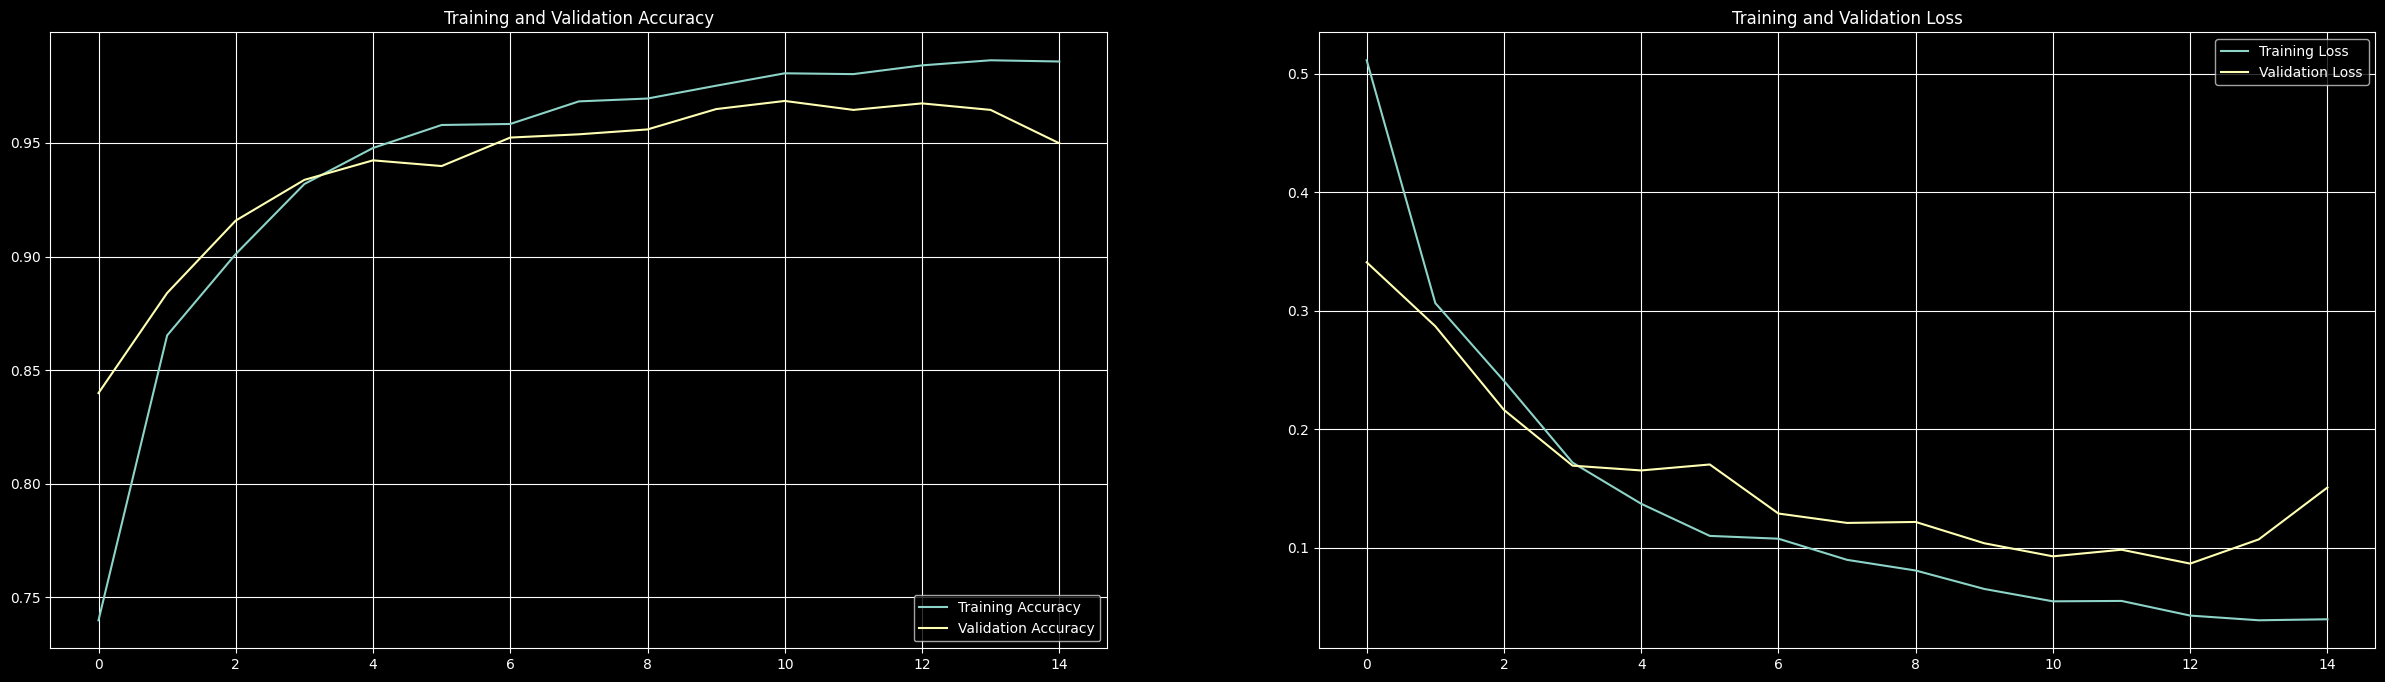

In [46]:
plt.style.use('dark_background')
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(num_epochs)

plt.figure(figsize=(30, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.grid()
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.grid()
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [51]:

# Evaluate the model on the final test set
loss, accuracy = model.evaluate(X_test, y_test_encoded)
print(f"Test loss: {loss:.4f}, Test accuracy: {accuracy:.4f}")


88/88 [==============================] - 1s 16ms/step - loss: 0.1253 - accuracy: 0.9617
Test loss: 0.1253, Test accuracy: 0.9617
